# Predict Future Sales

## Imports

In [1]:
import pandas as pd
pd.set_option('float_format', '{0:.2f}'.format)

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

## Import data

In [2]:
train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

In [3]:
df_train = train.copy()

## Data Cleaning

### Cleaning the training set

In [4]:
df_train.rename(columns={'item_cnt_day' : 'item_volume'}, inplace=True)

In [5]:
# Replace negative price
df_train["item_price"] = np.where(df_train.item_price < 0,
                            df_train[(df_train.date_block_num==4) & (df_train.shop_id==32) & (df_train.item_id==2973)]["item_price"].median(),
                            df_train.item_price)

#### Remove outliers

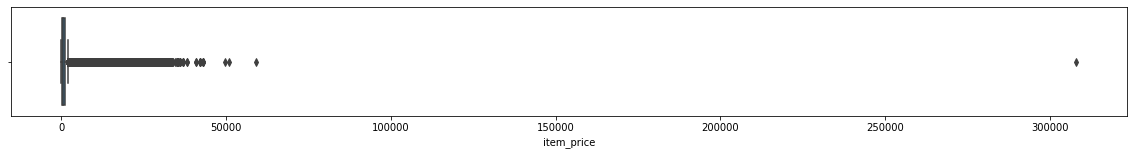

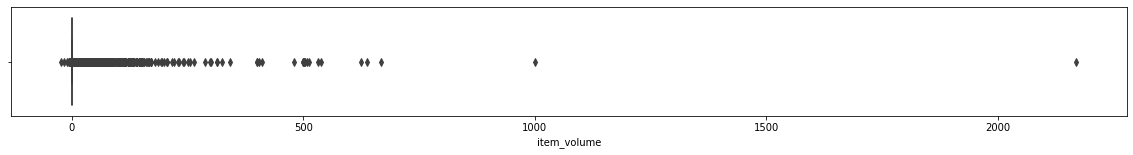

In [6]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

In [7]:
# Remove outliers
df_train = df_train[df_train.item_price < 100000]
df_train = df_train[df_train.item_volume < 100]

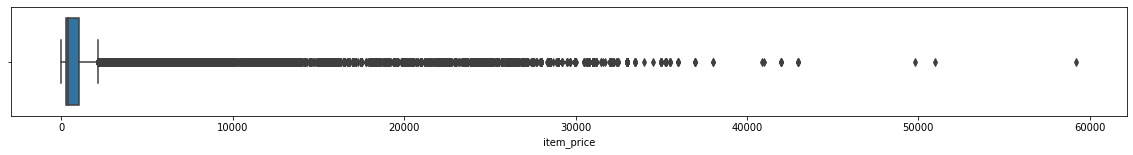

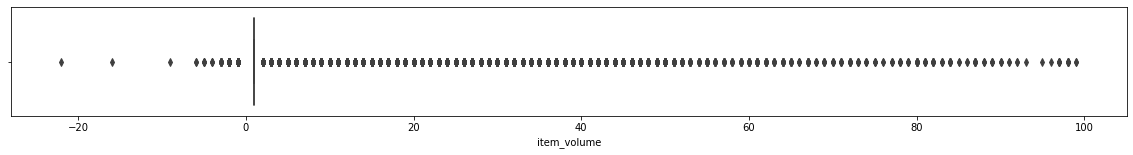

In [8]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

### Group by Month, Shop & Item

In [9]:
df_train["date"] = pd.to_datetime(df_train["date"], format='%d.%m.%Y')
df_train["month"] = df_train["date"].dt.month
df_train["year"] = df_train["date"].dt.year
#df_train["month_year"] = df_train["date"].dt.strftime('%Y-%m')
#df_train["month_year"] = pd.to_datetime(df_train["month_year"])

In [10]:
gp = df_train.groupby(["date_block_num", "year", "month", "shop_id", "item_id"]).agg({'item_volume' : 'sum', 'item_price' : 'mean'}).reset_index()

In [11]:
gp

,date_block_num,year,month,shop_id,item_id,item_volume,item_price
0,0,2013,1,0,32,6.00,221.00
1,0,2013,1,0,33,3.00,347.00
2,0,2013,1,0,35,1.00,247.00
3,0,2013,1,0,43,1.00,221.00
4,0,2013,1,0,51,2.00,128.50
...,...,...,...,...,...,...,...
1609112,33,2015,10,59,22087,6.00,119.00
1609113,33,2015,10,59,22088,2.00,119.00
1609114,33,2015,10,59,22091,1.00,179.00
1609115,33,2015,10,59,22100,1.00,629.00


In [12]:
# VOLUME CAN BE 0 (returns are negative)
df_train[(df_train.item_id==5643) & (df_train.date_block_num==0) & (df_train.shop_id==2)]

,date,date_block_num,shop_id,item_id,item_price,item_volume,month,year
32745,2013-01-02,0,2,5643,2385.21,-1.00,1,2013
32746,2013-01-06,0,2,5643,2390.00,1.00,1,2013


### Prepare test set and concatenate with training set

In [13]:
df_test = test.copy()

In [14]:
df_test["date_block_num"] = 34
df_test["year"] = 2015
df_test["month"] = 11
df_test["item_volume"] = 0
#df_test["item_price"] = 0

In [15]:
df_test

,ID,shop_id,item_id,date_block_num,year,month,item_volume
0,0,5,5037,34,2015,11,0
1,1,5,5320,34,2015,11,0
2,2,5,5233,34,2015,11,0
3,3,5,5232,34,2015,11,0
4,4,5,5268,34,2015,11,0
...,...,...,...,...,...,...,...
214195,214195,45,18454,34,2015,11,0
214196,214196,45,16188,34,2015,11,0
214197,214197,45,15757,34,2015,11,0
214198,214198,45,19648,34,2015,11,0


In [16]:
# Compute item_price for test set
gp_temp = df_train.groupby(["shop_id", "item_id"]).agg({'item_price' : 'mean'}).reset_index()
df_test = pd.merge(df_test, gp_temp, on=["shop_id", "item_id"], how='left')

In [17]:
df_test = df_test[["date_block_num", "year", "month", "shop_id", "item_id", "item_volume", "item_price"]]

In [18]:
df = pd.concat([gp, df_test], ignore_index=True)

In [19]:
df["revenue"] = df["item_volume"] * df["item_price"]

In [20]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823317 entries, 0 to 1823316
Data columns (total 8 columns):
date_block_num    int16
year              int16
month             int16
shop_id           int16
item_id           int16
item_volume       float32
item_price        float32
revenue           float32
dtypes: float32(3), int16(5)
memory usage: 38.3 MB


### Prepare Shops & Categories

In [22]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[["shop_id", "city_code"]]

In [23]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['cat'] = categories['split'].map(lambda x: x[0].strip())
categories['cat_code'] = LabelEncoder().fit_transform(categories['cat'])
# if subcategory is nan then category
categories['subcat'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subcat_code'] = LabelEncoder().fit_transform(categories['subcat'])
categories = categories[["item_category_id", "cat_code", "subcat_code"]]

In [24]:
items.drop(columns=["item_name"], axis=1, inplace=True)

### Merge & process dates

In [25]:
full_data = pd.merge(df, items, on=["item_id"], how='left')
full_data = pd.merge(full_data, categories, on="item_category_id", how='left')
full_data = pd.merge(full_data, shops, on="shop_id", how='left')

In [199]:
df = full_data.copy()

In [200]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,subcat_code,city_code
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,4,0
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,1,0
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,4,0
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,4,0
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,187.89,0.00,55,13,2,21
1823313,34,2015,11,45,16188,0.00,nan,nan,64,14,42,21
1823314,34,2015,11,45,15757,0.00,199.00,0.00,55,13,2,21
1823315,34,2015,11,45,19648,0.00,nan,nan,40,11,4,21


### KPIs

In [201]:
def _add_lag(df, index_columns, col_name, kpi, agg, lag=0):
    temp = df.groupby(index_columns).agg({ kpi : agg}).reset_index()
    temp["date_block_num"] = temp["date_block_num"] + lag
    if lag==0:
        lag_str = ""
    else:
        lag_str = "_" + str(lag)
    temp = temp.rename(columns={ kpi : (col_name + lag_str) })
    df = pd.merge(df, temp, how='left', on = index_columns)
    # Avoid 0 volume
    df[col_name + lag_str] = np.where(df[col_name + lag_str]==0, 1, df[col_name + lag_str])
    if lag!=0:
        df[col_name + lag_str + "_trend"] = \
        (df["item_volume"] - df[col_name + lag_str]) / df[col_name + lag_str]
    return df

In [202]:
def _add_lag_item(df, lag=0):
    temp = df[["date_block_num", "item_id", "shop_id", "item_volume"]]
    temp["date_block_num"] = temp["date_block_num"] + lag   
    temp = temp.rename(columns={ "item_volume" : ("item_volume_" + str(lag)) })
    df = pd.merge(df, temp, how='left', on = ["date_block_num", "shop_id", "item_id"])
    # Avoid 0 volume
    df["item_volume_" + str(lag)] = np.where(df["item_volume_" + str(lag)]==0, 1, df["item_volume_" + str(lag)])
    df["item_volume_" + str(lag) + "_trend"] = \
    (df["item_volume"] - df["item_volume_" + str(lag)]) / df["item_volume_" + str(lag)]
    return df 

In [203]:
def _add_kpi(df, index_columns, col_name, kpi, agg):
    temp = df.groupby(index_columns).agg({ kpi : agg}).reset_index()
    temp = temp.rename(columns={ kpi : col_name })
    df = pd.merge(df, temp, how='left', on = index_columns)
    return df

#### Mean

In [204]:
# Avg sales volume per shop
df = _add_kpi(df, ["shop_id"], "mean_volume_shop", "item_volume", "mean")
# Avg sales volume per category
df = _add_kpi(df, ["item_category_id"], "mean_volume_category", "item_volume", "mean")
# Avg sales volume per category, subcat
df = _add_kpi(df, ["item_category_id", "subcat_code"], "mean_volume_category_subcat", "item_volume", "mean")
# Avg sales volume per shop, category
df = _add_kpi(df, ["shop_id", "item_category_id"], "mean_volume_shop_category", "item_volume", "mean")
# Avg sales volume per shop, category, subcat
df = _add_kpi(df, ["shop_id", "item_category_id", "subcat_code"], "mean_volume_shop_category_subcat", "item_volume", "mean")

# Avg sales volume per month
df = _add_kpi(df, ["month"], "mean_volume_month", "item_volume", "mean")
# Avg sales volume per month, shop
df = _add_kpi(df, ["month", "shop_id"], "mean_volume_month_shop", "item_volume", "mean")
# Avg sales volume per month, category
df = _add_kpi(df, ["month", "item_category_id"], "mean_volume_month_category", "item_volume", "mean")
# Avg sales volume per month, category, subcat
df = _add_kpi(df, ["month", "item_category_id", "subcat_code"], "mean_volume_month_category_subcat", "item_volume", "mean")
# Avg sales volume per month, shop, category
df = _add_kpi(df, ["month", "shop_id", "item_category_id"], "mean_volume_month_shop_category", "item_volume", "mean")
# Avg sales volume per month, shop, category, subcat
df = _add_kpi(df, ["month", "shop_id", "item_category_id", "subcat_code"], "mean_volume_month_shop_category_subcat", "item_volume", "mean")

#### Lags

In [205]:
# Lag 1 month Sum of item_volume groupby month
df = _add_lag(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month
df = _add_lag(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 12)

# Lag 1 month Sum of item_volume groupby month, shop
df = _add_lag(df, ["date_block_num", "shop_id"], "sum_volume_month_shop", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month, shop
df = _add_lag(df, ["date_block_num", "shop_id"], "sum_volume_month_shop", "item_volume", "sum", 12)

# Lag 1 month Sum of item_volume groupby month, category
df = _add_lag(df, ["date_block_num", "item_category_id"], "sum_volume_month_category", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month, category
df = _add_lag(df, ["date_block_num", "item_category_id"], "sum_volume_month_category", "item_volume", "sum", 12)

# Lag 1 month Sum of item_volume groupby month, category, subcat
df = _add_lag(df, ["date_block_num", "item_category_id", "subcat_code"], "sum_volume_month_category_subcat", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month, category, subcat
df = _add_lag(df, ["date_block_num", "item_category_id", "subcat_code"], "sum_volume_month_category_subcat", "item_volume", "sum", 12)

# Lag 1 month Sum of item_volume groupby month, shop, category
df = _add_lag(df, ["date_block_num", "shop_id", "item_category_id"], "sum_volume_month_shop_category", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month, shop, category
df = _add_lag(df, ["date_block_num", "shop_id", "item_category_id"], "sum_volume_month_shop_category", "item_volume", "sum", 12)

# Lag 1 month Sum of item_volume groupby month, shop, category, subcat
df = _add_lag(df, ["date_block_num", "shop_id", "item_category_id", "subcat_code"], "sum_volume_month_shop_category_subcat", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month, shop, category, subcat
df = _add_lag(df, ["date_block_num", "shop_id", "item_category_id", "subcat_code"], "sum_volume_month_shop_category_subcat", "item_volume", "sum", 12)

In [206]:
# Lag 1 month Sum of item_volume
df = _add_lag_item(df, 1)
# Lag 12 month Sum of item_volume
df = _add_lag_item(df, 12)

c:\users\traouz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [207]:
def _add_lag_revenue(df, lag=0):
    temp = df[["date_block_num", "item_id", "shop_id", "revenue"]]
    temp["date_block_num"] = temp["date_block_num"] + lag   
    temp = temp.rename(columns={ "revenue" : ("revenue_" + str(lag)) })
    df = pd.merge(df, temp, how='left', on = ["date_block_num", "shop_id", "item_id"])
    # Avoid 0 volume
    df["revenue_" + str(lag)] = np.where(df["revenue_" + str(lag)]==0, 1, df["revenue_" + str(lag)])
    df["revenue_" + str(lag) + "_trend"] = \
    (df["revenue"] - df["revenue_" + str(lag)]) / df["revenue_" + str(lag)]
    return df 

In [208]:
# Lag 1 month Sum of item_volume
df = _add_lag_revenue(df, 1)
# Lag 12 month Sum of item_volume
df = _add_lag_revenue(df, 12)

c:\users\traouz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [209]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,...,sum_volume_month_shop_category_subcat_12,sum_volume_month_shop_category_subcat_12_trend,item_volume_1,item_volume_1_trend,item_volume_12,item_volume_12_trend,revenue_1,revenue_1_trend,revenue_12,revenue_12_trend
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,187.89,0.00,55,13,...,124.00,-1.00,1.00,-1.00,nan,nan,99.00,-1.00,nan,nan
1823313,34,2015,11,45,16188,0.00,nan,nan,64,14,...,16.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan
1823314,34,2015,11,45,15757,0.00,199.00,0.00,55,13,...,124.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan
1823315,34,2015,11,45,19648,0.00,nan,nan,40,11,...,128.00,-1.00,nan,nan,nan,nan,nan,nan,nan,nan


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823317 entries, 0 to 1823316
Data columns (total 55 columns):
date_block_num                                    int16
year                                              int16
month                                             int16
shop_id                                           int16
item_id                                           int16
item_volume                                       float32
item_price                                        float32
revenue                                           float32
item_category_id                                  int64
cat_code                                          int32
subcat_code                                       int32
city_code                                         int32
mean_volume_shop                                  float32
mean_volume_category                              float32
mean_volume_category_subcat                       float32
mean_volume_shop_category          

In [211]:
df_prepared = df.copy()
#df = df_prepared.copy()

In [212]:
df = df.fillna(0)

# Model

In [213]:
train_val = df[df.date_block_num.isin(range(12,34))]

X_test = df[df.date_block_num==34].drop(columns=["item_volume"])

In [214]:
train_val = train_val[train_val.shop_id.isin(X_test.shop_id.unique())]
train_val = train_val[train_val.item_id.isin(X_test.item_id.unique())]

In [215]:
X_train = train_val[(train_val.date_block_num.isin(range(12,34))) & (df.date_block_num!=22)].drop(columns=["item_volume"])
y_train = train_val[(train_val.date_block_num.isin(range(12,34))) & (df.date_block_num!=22)]["item_volume"]

X_val = train_val[train_val.date_block_num==22].drop(columns=["item_volume"])
y_val = train_val[train_val.date_block_num==22]["item_volume"]

c:\users\traouz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
c:\users\traouz\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [216]:
columns_to_del = ["revenue", "item_category_id",
                 #"mean_volume_category", 
                 #"city_code", "cat_code", "subcat_code",
                # "revenue_1_trend", "revenue_12_trend",
                  #"year", "shop_id", 
                #  "mean_volume_shop_category",
               #   "revenue_12", "item_volume_12", "sum_volume_month_category_12",
                 ]

In [217]:
X_train.drop(columns=columns_to_del, inplace=True)

In [218]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [219]:
X_val.drop(columns=columns_to_del, inplace=True)
X_val = scaler.transform(X_val)

In [220]:
X_test.drop(columns=columns_to_del, inplace=True)
X_test = scaler.transform(X_test)

In [221]:
#df[df.date_block_num==34].drop(columns=["item_volume"]).to_csv('X_test.csv', index=False)
#df[df.date_block_num==33].drop(columns=["item_volume"]).to_csv('X_val.csv', index=False)

#### Neural Network

In [222]:
import tensorflow as tf
from tensorflow import keras

#from kerastuner.tuners import RandomSearch

In [223]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=X_train.shape[1:]),
    keras.layers.Dense(3, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(3, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1)
])
#model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3,clipnorm=1), metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [224]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [225]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
14158/14158 [==============================] - 22s 1ms/step - loss: 27.0908 - root_mean_squared_error: 4.9291 - val_loss: 4.2015 - val_root_mean_squared_error: 2.0498
Epoch 2/50
14158/14158 [==============================] - 20s 1ms/step - loss: 2.1943 - root_mean_squared_error: 1.4713 - val_loss: 2.2530 - val_root_mean_squared_error: 1.5010
Epoch 3/50
14158/14158 [==============================] - 20s 1ms/step - loss: 1.7558 - root_mean_squared_error: 1.3061 - val_loss: 4.1621 - val_root_mean_squared_error: 2.0401
Epoch 4/50
14158/14158 [==============================] - 18s 1ms/step - loss: 2.2529 - root_mean_squared_error: 1.4965 - val_loss: 3.8400 - val_root_mean_squared_error: 1.9596
Epoch 5/50
14158/14158 [==============================] - 19s 1ms/step - loss: 1.7135 - root_mean_squared_error: 1.3026 - val_loss: 1.7497 - val_root_mean_squared_error: 1.3228
Epoch 6/50
14158/14158 [==============================] - 20s 1ms/step - loss: 1.8073 - root_mean_squared_error: 1

In [226]:
model.evaluate(X_val, y_val)

701/701 [==============================] - 1s 923us/step - loss: 0.6643 - root_mean_squared_error: 0.8151


[0.6643279194831848, 0.8150631189346313]

## Submission

In [187]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 147       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 163
Trainable params: 163
Non-trainable params: 0
__________________________________________________________

In [227]:
y_test = model.predict(X_test).clip(0,20)

In [228]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test.reshape([-1])
})
submission.to_csv('submission.csv', index=False)